# Stacking Ensemble

Stacking ensemble methods use the results from a number of other models, and uses a meta-estimator to learn the relationships between the prediction results of the first layer of models to produce a final prediction. For this experiment, a combination of the naive bayes, logistic regression, support vector machine, random forest, and XGBoost models will be used in the sklearn.ensemble.StackingClassifier model. The meta-estimator will be a logistic regression model, since more complex models are often not chosen as the meta-estimator since they may overfit easier. 

In [1]:
#libaries
from sklearn.ensemble import StackingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.metrics import classification_report
import pickle
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the augmented data from the file
data = np.load('/content/drive/Shareddrives/SignLanguageData/combined_features_pca_lda.npz')
#unpacking 
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']
#printing shapes 
print(f'X_train Shape: {X_train.shape}')
print(f'y_train Shape: {y_train.shape}')
print(f'X_test Shape: {X_test.shape}')
print(f'y_test Shape: {y_test.shape}')

X_train Shape: (109820, 53)
y_train Shape: (109820,)
X_test Shape: (28688, 53)
y_test Shape: (28688,)


Defining all models as estimators using the best parameters found in previous experiment notebooks. 

In [8]:
#downloading models with best parameters 
with open('/content/drive/Shareddrives/SignLanguageData/FinalSVM.pkl','rb') as f:
  svm = pickle.load(f)

with open('/content/drive/Shareddrives/SignLanguageData/FinalXGB.pkl','rb') as f:
  xgb = pickle.load(f)

with open('/content/drive/Shareddrives/SignLanguageData/lr_model.pkl','rb') as f:
  lr = pickle.load(f) 

with open('/content/drive/Shareddrives/SignLanguageData/rfc_model.pkl','rb') as f:
  rf = pickle.load(f)

In [21]:
#defining estimators 
all_estimators = [
    ('svm',SVC(kernel = 'poly', gamma = 'auto', C = .1, probability=True)),
    ('xgb',xgb.XGBClassifier(subsample=0.4,reg_lambda=2.25,reg_alpha=2,min_child_weight=30,max_depth=8,learning_rate=0.001,gamma=0,colsample_bytree=0.4)),
    ('lr',LogisticRegression(C=0.22564631610840102,max_iter=2391, penalty="l2", solver='newton-cg',warm_start=False)),
    ('rf',RandomForestClassifier(n_estimators=20, min_samples_split=10, min_samples_leaf=5,max_features=5, max_depth=5, random_state=42))
]

In [23]:
#training stacking classifier 
all_stack = StackingClassifier(estimators=all_estimators, final_estimator=LogisticRegression(max_iter=3000))
all_stack.fit(X_train,y_train)

#predictions 
y_pred_train = all_stack.predict(X_train)
y_pred_test = all_stack.predict(X_test)

In [24]:
with open('/content/drive/Shareddrives/SignLanguageData/stacking_ensemble.pkl','wb') as f:
  pickle.dump(all_stack,f)

In [25]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,matthews_corrcoef,cohen_kappa_score,accuracy_score

def evaluate_model(y_true, y_pred, labels):
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy}")
    
    # Classification report
    print("Classification report:")
    print(classification_report(y_true, y_pred, target_names=labels))
    
    # Matthews Correlation Coefficient (MCC)
    mcc = matthews_corrcoef(y_true, y_pred)
    print(f"MCC: {mcc}")
    
    # Cohen's Kappa
    kappa = cohen_kappa_score(y_true, y_pred)
    print(f"Cohen's Kappa: {kappa}")
    
    # Confusion Matrix
    cm = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=labels)
    fig, ax = plt.subplots(figsize=(16,14))  # set figure size
    cm.plot(cmap='BuPu', ax=ax)  # set color map and axis
    plt.title("Confusion Matrix")
    plt.show()

In [26]:
#classification report for train
print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94      4504
         1.0       0.97      0.97      0.97      4040
         2.0       0.99      0.99      0.99      4576
         3.0       0.96      0.96      0.96      4784
         4.0       0.96      0.95      0.95      3828
         5.0       0.98      0.98      0.98      4816
         6.0       0.96      0.96      0.96      4360
         7.0       0.97      0.97      0.97      4052
         8.0       0.96      0.94      0.95      4648
        10.0       0.95      0.97      0.96      4456
        11.0       0.99      0.99      0.99      4964
        12.0       0.89      0.89      0.89      4220
        13.0       0.91      0.91      0.91      4604
        14.0       0.99      0.99      0.99      4784
        15.0       1.00      1.00      1.00      4352
        16.0       0.99      0.99      0.99      5116
        17.0       0.94      0.93      0.93      5176
        18.0       0.92    

In [27]:
#classification report for test 
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

         0.0       0.85      0.92      0.89      1324
         1.0       0.96      0.87      0.91      1728
         2.0       0.98      0.96      0.97      1240
         3.0       0.85      0.88      0.87       980
         4.0       0.86      0.90      0.88      1992
         5.0       0.95      0.94      0.95       988
         6.0       0.90      0.85      0.87      1392
         7.0       0.96      0.93      0.94      1744
         8.0       0.89      0.87      0.88      1152
        10.0       0.86      0.89      0.88      1324
        11.0       0.94      0.99      0.96       836
        12.0       0.74      0.74      0.74      1576
        13.0       0.70      0.66      0.68      1164
        14.0       0.96      0.91      0.93       984
        15.0       0.98      0.99      0.99      1388
        16.0       0.89      0.98      0.93       656
        17.0       0.52      0.75      0.62       576
        18.0       0.65    

In [5]:
with open('/content/drive/Shareddrives/SignLanguageData/stacking_ensemble.pkl','rb') as f:
  stack = pickle.load(f)

In [4]:
#function for sampling
def sampler(X,y,num_sample):
  indices = np.random.choice(X.shape[0], num_sample, replace=False)
  return X[indices,:],y[indices]

In [6]:
X_train_sample,y_train_sample = sampler(X_train,y_train,30000)
X_test_sample,y_test_sample = sampler(X_test,y_test,7000)

In [7]:
y_pred_train = stack.predict(X_train_sample)
y_pred_test = stack.predict(X_test_sample)

In [10]:

from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,matthews_corrcoef,cohen_kappa_score,accuracy_score
import matplotlib.pyplot as plt

def evaluate_model(y_true, y_pred, labels):
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy}")
    
    # Classification report
    print("Classification report:")
    print(classification_report(y_true, y_pred, target_names=labels))
    
    # Matthews Correlation Coefficient (MCC)
    mcc = matthews_corrcoef(y_true, y_pred)
    print(f"MCC: {mcc}")
    
    # Cohen's Kappa
    kappa = cohen_kappa_score(y_true, y_pred)
    print(f"Cohen's Kappa: {kappa}")
    
    # Confusion Matrix
    cm = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=labels)
    fig, ax = plt.subplots(figsize=(16,14))  # set figure size
    cm.plot(cmap='BuPu', ax=ax)  # set color map and axis
    plt.title("Confusion Matrix")
    plt.show()

Accuracy: 0.9586
Classification report:
              precision    recall  f1-score   support

           A       0.93      0.95      0.94      1207
           B       0.98      0.98      0.98      1069
           C       0.99      0.99      0.99      1239
           D       0.97      0.96      0.96      1334
           E       0.95      0.95      0.95      1038
           F       0.99      0.98      0.99      1338
           G       0.96      0.95      0.96      1174
           H       0.96      0.97      0.97      1089
           I       0.96      0.94      0.95      1253
           K       0.95      0.97      0.96      1201
           L       0.99      0.99      0.99      1366
           M       0.89      0.90      0.89      1122
           N       0.91      0.90      0.91      1286
           O       0.99      0.99      0.99      1330
           P       1.00      1.00      1.00      1213
           Q       1.00      1.00      1.00      1421
           R       0.94      0.94      0.

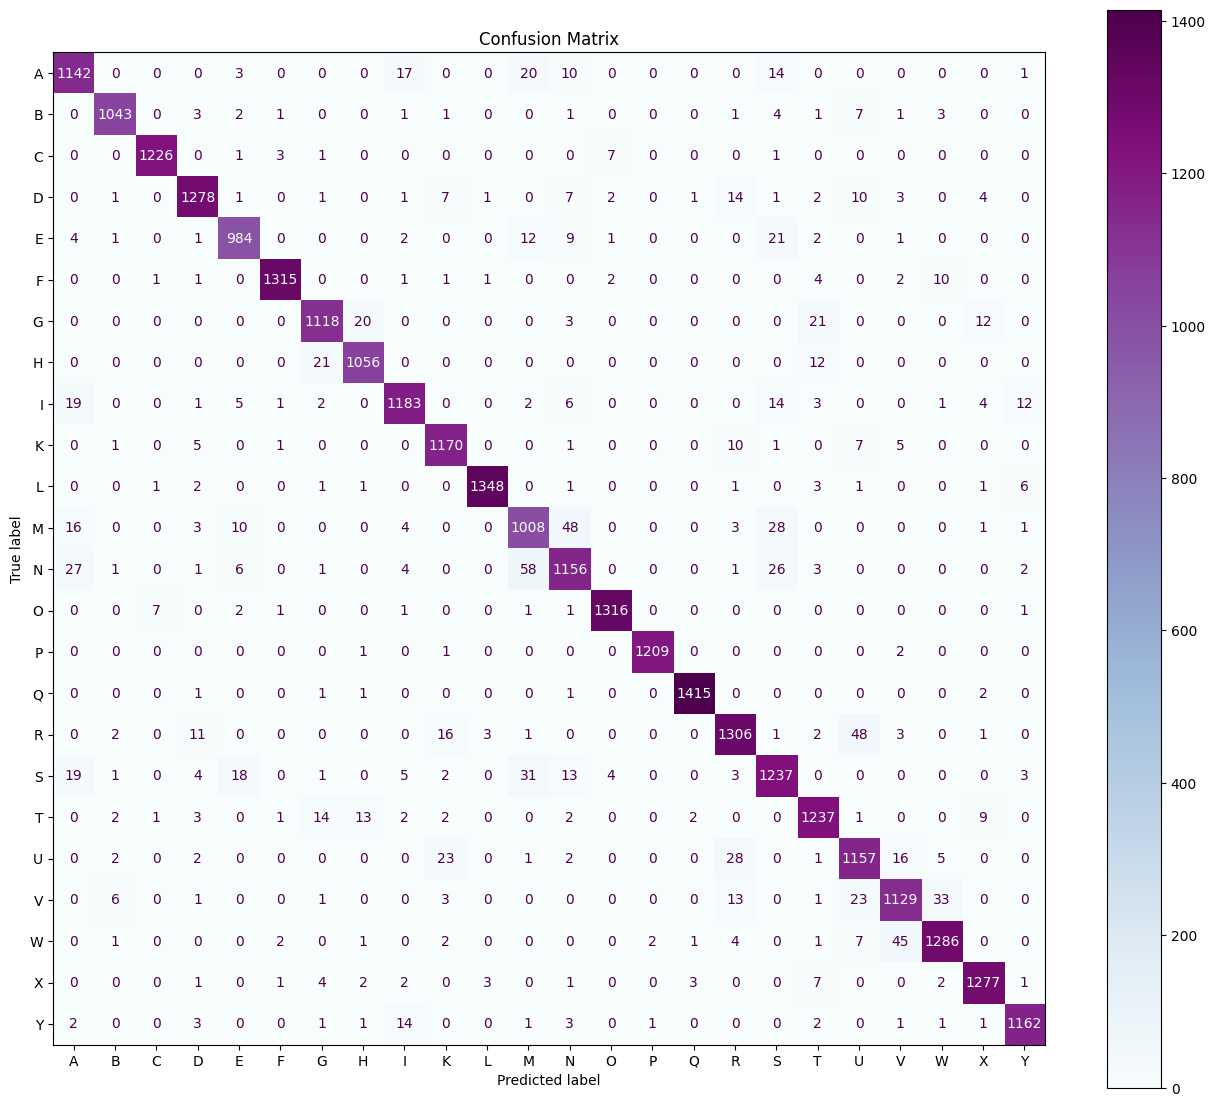

In [12]:
letters = ['A','B','C','D','E','F','G','H','I','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y']
evaluate_model(y_train_sample,y_pred_train,letters)

Accuracy: 0.8591428571428571
Classification report:
              precision    recall  f1-score   support

           A       0.85      0.91      0.88       340
           B       0.94      0.89      0.91       423
           C       0.98      0.99      0.98       295
           D       0.87      0.89      0.88       232
           E       0.85      0.92      0.88       476
           F       0.96      0.95      0.95       256
           G       0.88      0.89      0.89       333
           H       0.97      0.92      0.95       406
           I       0.87      0.89      0.88       282
           K       0.86      0.91      0.88       320
           L       0.92      0.99      0.95       217
           M       0.77      0.76      0.76       397
           N       0.69      0.64      0.67       274
           O       0.98      0.92      0.95       236
           P       0.98      0.99      0.99       349
           Q       0.90      0.97      0.93       154
           R       0.55      

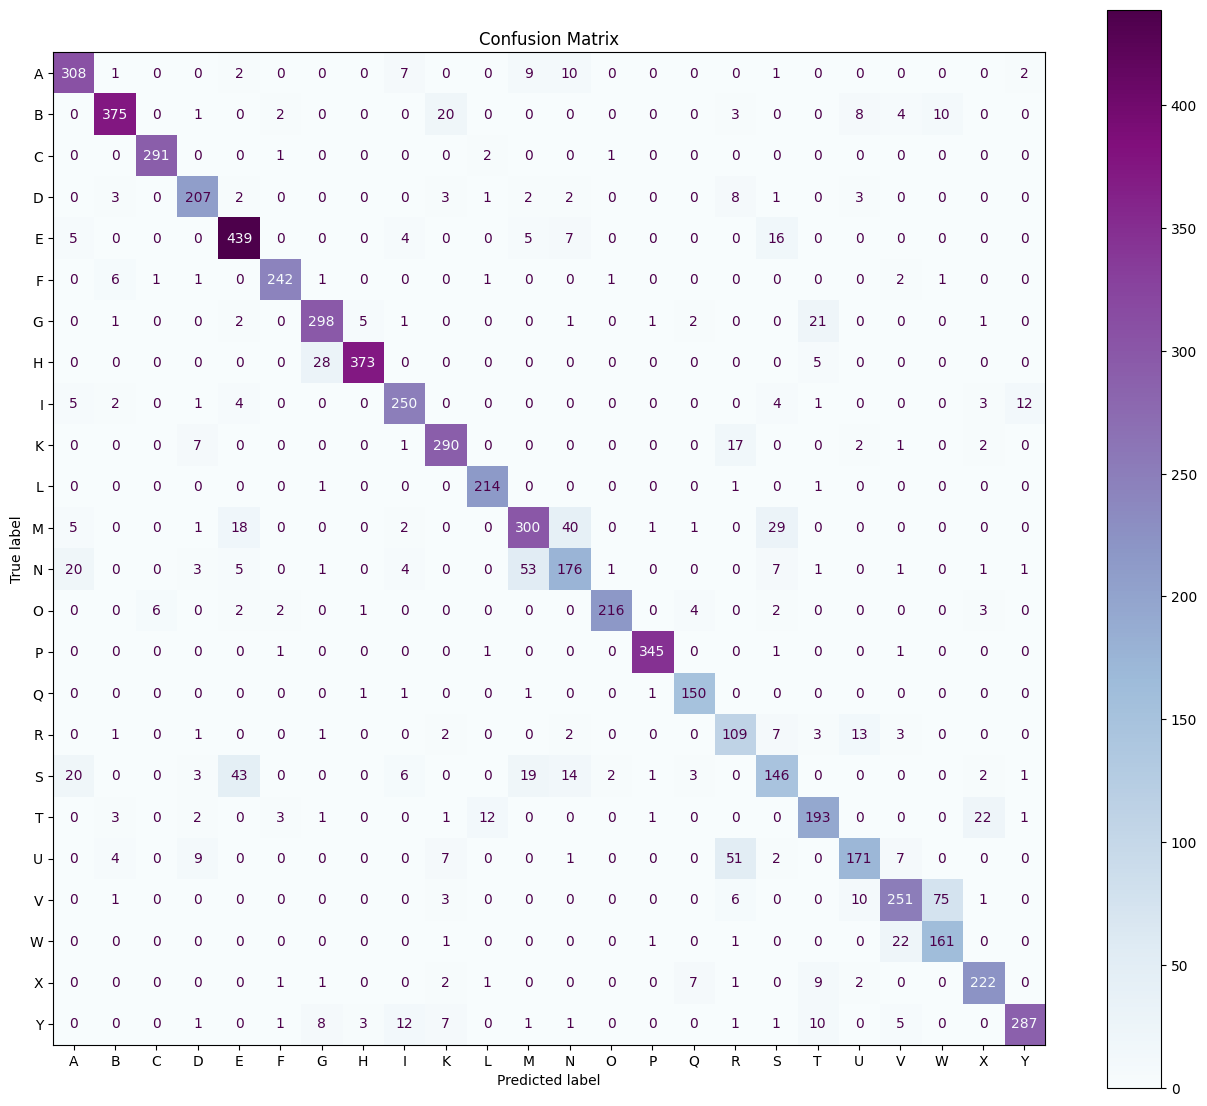

In [13]:
evaluate_model(y_test_sample,y_pred_test,letters)